This homework is due Tuesday, October 23, 2018.

Each question is worth 25 points.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pylab as plt
import pandas as pd
import scipy.stats as sps
from scipy.optimize import minimize
# Set seed
np.random.seed(10011)

# Question 1

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1-p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta - \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

## 1.1

First, put together function and optimize, based on formula above

In [2]:
#define posterior based on prompt, find log-odd based on θ=log(p/(1-p))
log_odds_posterior=lambda θ,y,n,μ,σ:np.log((np.exp(y*θ)/((1+np.exp(θ))**n))*(np.exp(-(θ-μ)**2)/(2*σ**2)))

In [3]:
#given y,n,μ,σ optimize for θ
def posterior(θ,var): 
    y,n,μ,σ=var
    return((log_odds_posterior(θ,y,n,μ,σ)))

"A priori we believe that the coin is fair, so we assign θ a N(0,.25) prior. We toss the coin n=5 times and obtain y=5 heads."

So we initialize our parameters as 5,5,0,.25 assuming a fair coin

In [4]:
#minimize using default bfgs
minimized=minimize(posterior,1,args=[5,5,0,.25],method="BFGS")
minimized

      fun: array([-0.4868669])
 hess_inv: array([[1]])
      jac: array([-0.65529294])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 336
      nit: 0
     njev: 108
   status: 2
  success: False
        x: array([1.])

In [5]:
minimized.x #this should be where we center some simulated distribution

array([1.])

In [6]:
minimized.hess_inv #the sqrt of this should be the scaling value we use for the simulated distribution

array([[1]])

Second, run a simulation based on parameters obtained from optimization.

In [7]:
def biased_coin_simulation(flips,minimized_func,bin_num):
    sim=np.random.normal(minimized_func.x,np.sqrt(minimized.hess_inv[0][0]),flips)
    plt.hist(sim,bins=bin_num)
    return(sim)

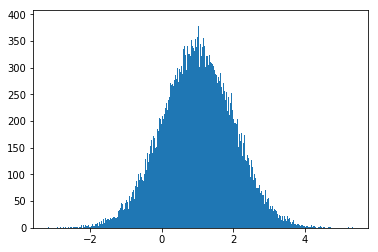

In [9]:
sim=biased_coin_simulation(100000,minimized,1000)

It doesn't look like the minimization worked as well as it could but the distribution looks pretty reasonable for a biased coin ... somehow.

Third, we calculate the degree of bias given that any value above 0 is heads based on, "compute the probability that the coin is biased toward heads (i.e., that θ is positive)."

In [11]:
np.mean(sim>0) #take the mean of the values above 0

0.84209

If the coin was fair, I would have guessed that this value would be zero or much closer to zero. There is a 84.2% chance that the coin is biased towards heads.

## 1.2

I think for the rejection algorithm I need to ensure the following, so we need a new approximation method (Section4_1): $\log[f(\theta|y)] - \log[g(\theta)] \le c'$

In [12]:
def calc_diff(theta,y,n,mu,S):
        return log_odds_posterior(theta, y,n,mu,S) - np.log(sps.norm.pdf(theta, mu,S))

In [13]:
minimized_constrained=minimize(calc_diff,1,args=(5,5,0,.25))#

In [14]:
minimized_constrained

      fun: -2.0987098570387954
 hess_inv: array([[0.07840587]])
      jac: array([-9.95397568e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-0.19601793])

In [15]:
def reject(post, S, mu, n, y, c,flips,bin_num):
    #post=posterior
    #S=stdev,0.25
    #mu=mean,0
    #n=flips,5
    #y=heads,5
    #c=fun
    #y,n,μ,σ 
      
    # Draw samples from g(theta) #sample from normal distribution to get several thetas
    theta = np.random.normal(mu,S,flips)#rmvt(nu, S, mu, size=n)
    
    # Calculate probability under g(theta), simply use probability distribution function of a normal 
    gvals = np.array([np.log(sps.norm.pdf(t,mu,S)) for t in theta])#mvt(t, nu, S, mu)) for t in theta])

    # Calculate probability under f(theta) #for every t put values through 
    fvals = np.array([post(t,y,n,mu,S) for t in theta])

    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    sim=theta[np.random.random(flips) < p]
    
    plt.hist(sim,bins=bin_num)
    
    return(sim) 

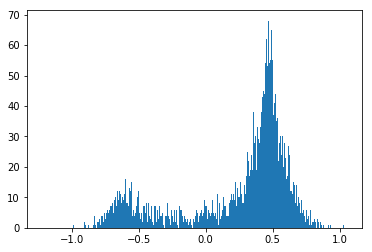

In [16]:
reject_sample=reject(calc_diff,0.25,0,5,5,minimized_constrained.fun,100000,1000)

In [17]:
np.mean(reject_sample>0) #take the mean of the values above 0

0.7710729104919977

Still pretty close to what we got in 1.1, still seems biased towards heads by a large margin.

## 1.3

Weighted bootstrapping through SIR (Section 4_1): $p_i = \frac{w(\theta_i)}{\sum_{i=1}^M w(\theta_i)}$

This time, it is not necessary to use the calc_diff approximation method, since we are just going to use the original posterior

In [18]:
def sir(post, S, mu, n, y, flips,bin_num):
    #post=posterior
    #S=stdev,0.25
    #mu=mean,0
    #n=flips,5
    #y=heads,5
    #c=fun
    #y,n,μ,σ 
    var=S,mu,n,y
      
    # Draw samples from g(theta) #sample from normal distribution to get several thetas
    theta = np.random.normal(mu,S,flips)#rmvt(nu, S, mu, size=n)
    
    # Calculate probability under g(theta), simply use probability distribution function of a normal 
    gvals = np.array(([(sps.norm.pdf(t,mu,S)) for t in theta]))#mvt(t, nu, S, mu)) for t in theta])

    # Calculate probability under f(theta) #for every t put values through 
    fvals = np.array(([post(t,var) for t in theta]))
    
    # Calculate weights
    w = np.exp(fvals - gvals - max(fvals - gvals))
    
    p_sir = w/w.sum()
       
    theta_sir = theta[np.random.choice(range(len(theta)), size=flips, p=p_sir)]
    
    plt.hist(theta_sir,bin_num)
    
    return(theta_sir) 

The biggest difference in this one is that I calculated weights, incorporated them into a probability distribution, and sampled from it. Also am not using the log odds

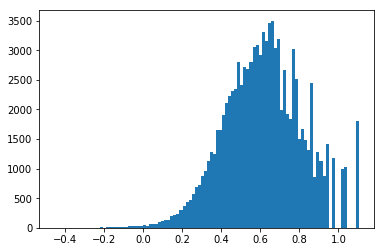

In [19]:
theta_sir=sir(posterior,0.25,0,5,5,100000,100)

In [20]:
np.mean(theta_sir) 

0.6199600899553718

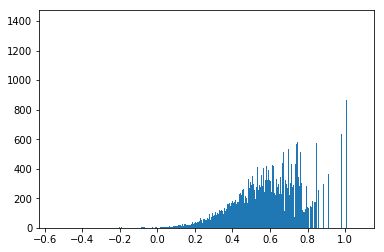

In [21]:
theta_sir=sir(posterior,0.25,0,5,5,100000,1000)

The histogram looks odd with more bins, but the center sort of makes sense relative to 1.1 and 1.2

# Question 2

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(-1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

## 2.1

Referenced https://docs.pymc.io/notebooks/gaussian_mixture_model.html

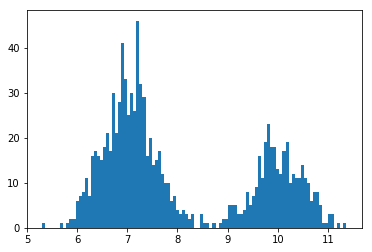

In [23]:
np.random.seed(12345) # set random seed for reproducibility

δ = 0.7 #delta variable
σ = 0.5 #it's convenient that both distributions have the same standard deviation
k = 2 #number of centers
ndata = 1000 #draws
centers = np.array([7,10]) #the μ's of our two normals

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata) #randomly generate a number for the given amount of centers from a discrete uniform distribution 
d = np.random.binomial(1, δ, ndata) #randomly generate a 0 or a 1 from 
data = centers[v*d] + σ*np.random.randn(ndata) #first part determines which distribution it is going to be a part of, second part just draws from a normal distribution with σ standard deviation

plt.hist(data,bins=100);

## 2.2

Modified from Section 4_2

Need to define a posterior first based on  $y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$ and take it's log probability 

In [24]:
mix_posterior=lambda δ,data: np.sum(np.log(δ*sps.norm.pdf(data,centers[0],σ)+(1-δ)*(sps.norm.pdf(data,centers[1],σ))))

In [25]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values,data,prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = mix_posterior(*trace[0],data)
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
            
            # Propose new value
            ##if j==2:
                ## Ensure tau is positive
                
            ϵ = np.random.uniform(-1,1) #error term for 2.2  
            theta = current_params[j] + ϵ #theta calculation using error term ##np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            ##else:
                ##theta = rnorm(current_params[j], prop_sd[j])
            
            #Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = mix_posterior(*p,data)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [26]:
trace_metro, accepted_metro = metropolis(10**4,[δ],data)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [27]:
np.array(accepted_metro, float)/10**4

array([0.0246])

Acceptance rate check, its pretty low at 0.02

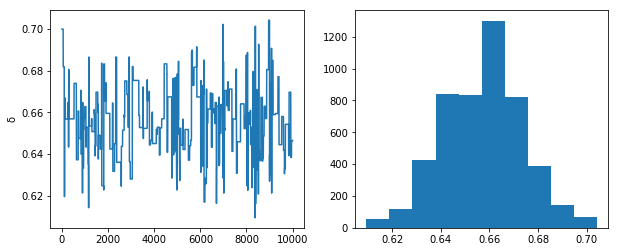

In [28]:
for param, samples in zip(['δ'], trace_metro.T):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(10**4/2):])

## 2.3

Need to perform a transformation into u space, this is only performed on the input into our posterior, so we can make things more convenient by just defining a new lambda function to operate just on those inputs. 

$U = \log\left[\frac{\delta}{1 - \delta}\right]$

In [29]:
u_transform=lambda x:(np.exp(x)/(1+np.exp(x)))

In [30]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis_u(n_iterations, initial_values,data,prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob_u = mix_posterior(u_transform(*trace[0]),data)
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
            
            # Propose new value
            ##if j==2:
                ## Ensure tau is positive
                
            ϵ = np.random.uniform(-1,1) #error term for 2.2  
            theta = current_params[j] + ϵ #theta calculation using error term ##np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            ##else:
                ##theta = rnorm(current_params[j], prop_sd[j])
            
            #Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value, but in uspace, so just 
            proposed_log_prob_u = mix_posterior(u_transform(*p),data)
    
            # Log-acceptance rate
            alpha = proposed_log_prob_u - current_log_prob_u
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob_u = proposed_log_prob_u
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

In [31]:
trace_metro, accepted_metro = metropolis_u(10**4,[δ],data)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [32]:
np.array(accepted_metro, float)/10**4

array([0.1067])

Acceptance rate check, wow it's way better. But it make sense since the transform kind of forces probabilities into specific values.

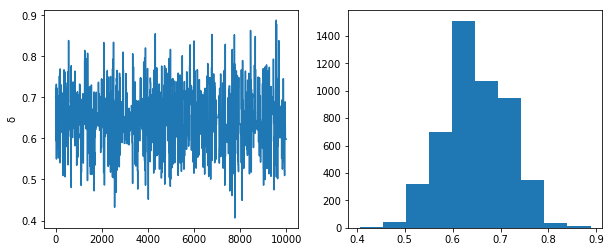

In [35]:
for param, samples in zip(['δ'], trace_metro.T):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(10**4/2):])

# Question 3

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use an appropriate metric to compare the models as approximations of the true generating model

Which model would you select and why?

## 3.1

The 4 possible models have to do with permutations of random or fixed population means and random or fixed treatment effects:

model 1 : fixed mean, fixed effect, should incorporate some set constants for normal distributions

model 2 : fixed mean, random effect, should incorporate some set constants for normal distributions but only for mean

model 3 : random mean, fixed effect, should incorporate some set constants for normal distributions but only for effect

model 4 : random mean, random effect, should not incorporate any set constants for normal distributions

Referenced https://docs.pymc.io/notebooks/model_comparison.html

In [36]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22] #trial 
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

Model 1 : fixed mean, fixed effect, should incorporate some set constants for normal distributions

No problems here.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μi, δi]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3014.42draws/s]
/usr/people/chenb3/.conda/envs/pcreodeEnv/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8860159647618869, but should be close to 0.8. Try to increase the number of tuning steps.


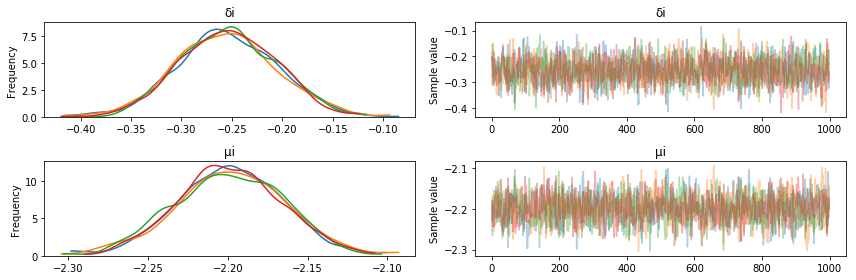

In [37]:
with pm.Model() as model_1:
    #Don't need to define σ and μ in this case because we only have a fixed mean and effect
    δi = pm.Normal("δi", mu=0, sd=5)
    μi = pm.Normal("μi", mu=0, sd=5)
    
    pci = pm.math.invlogit(μi)
    pti = pm.math.invlogit(μi + δi)
    
    rci = pm.Binomial("rci",n_c_obs,pci,observed=r_c_obs)
    rti = pm.Binomial("rti",n_t_obs,pti,observed=r_t_obs)
    
    trace_1 = pm.sample(1000)
    pm.traceplot(trace_1)

Model 2 : fixed mean, random effect, should incorporate some set constants for normal distributions but only for mean

No issues running this one.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μi, δi, μ, σ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1202.84draws/s]
/usr/people/chenb3/.conda/envs/pcreodeEnv/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


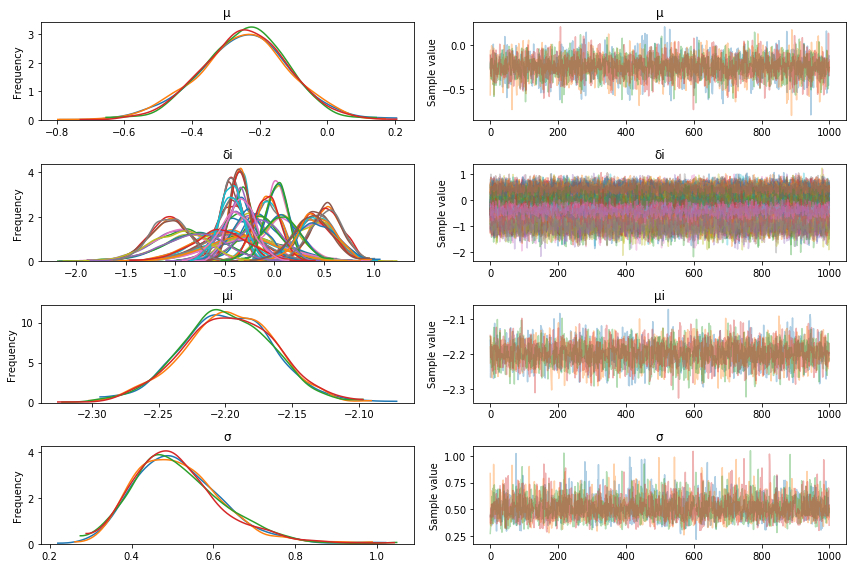

In [38]:
with pm.Model() as model_2:
    #Need to define sd and 
    σ = pm.HalfCauchy("σ",5)
    μ = pm.Normal("μ", 0, sd = 1e6)
    
    δi = pm.Normal("δi", mu=μ, sd = σ, shape = 22)
    μi = pm.Normal("μi", mu=0, sd = 5)
    
    pci = pm.math.invlogit(μi)
    pti = pm.math.invlogit(μi + δi)
    
    rci = pm.Binomial("rci",n_c_obs,pci,observed=r_c_obs)
    rti = pm.Binomial("rti",n_t_obs,pti,observed=r_t_obs)

    trace_2 = pm.sample(1000)
    pm.traceplot(trace_2)

Model 3 : random mean, fixed effect, should incorporate some set constants for normal distributions but only for effect

Pretty much the same as Model 2, so no issues here either

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μi, δi, μ, σ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1618.21draws/s]
/usr/people/chenb3/.conda/envs/pcreodeEnv/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


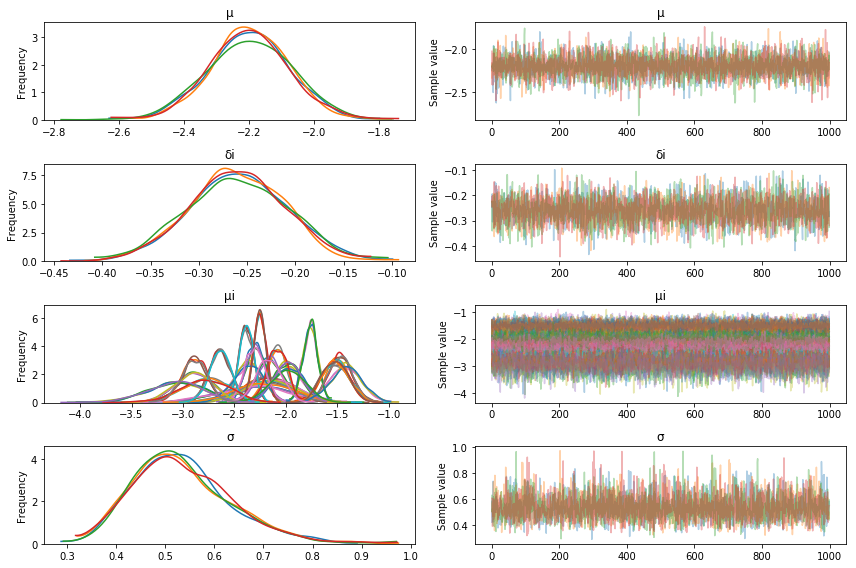

In [39]:
with pm.Model() as model_3:
    #Need to define sd and 
    σ = pm.HalfCauchy("σ",5)
    μ = pm.Normal("μ", 0, sd = 1e6)
    
    δi = pm.Normal("δi", mu=0, sd=5)
    μi = pm.Normal("μi", mu=μ, sd = σ, shape = 22)
    
    pci = pm.math.invlogit(μi)
    pti = pm.math.invlogit(μi + δi)
    
    rci = pm.Binomial("rci",n_c_obs,pci,observed=r_c_obs)
    rti = pm.Binomial("rti",n_t_obs,pti,observed=r_t_obs)

    trace_3 = pm.sample(1000)
    pm.traceplot(trace_3)

Model 4 : random mean, random effect, should not incorporate any set constants for normal distributions

This one was interesting to figure out, I tried using the same random σ and μ but this would lead to chain failures.

Kept getting errors with only 1000 tuning steps like in the referenced example: "There were 16 divergences after tuning. Increase `target_accept` or reparameterize." So I increased the tuning steps to 2000 then 3000.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μi, δi, μb, σb, μa, σa]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:22<00:00, 626.30draws/s]
/usr/people/chenb3/.conda/envs/pcreodeEnv/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective

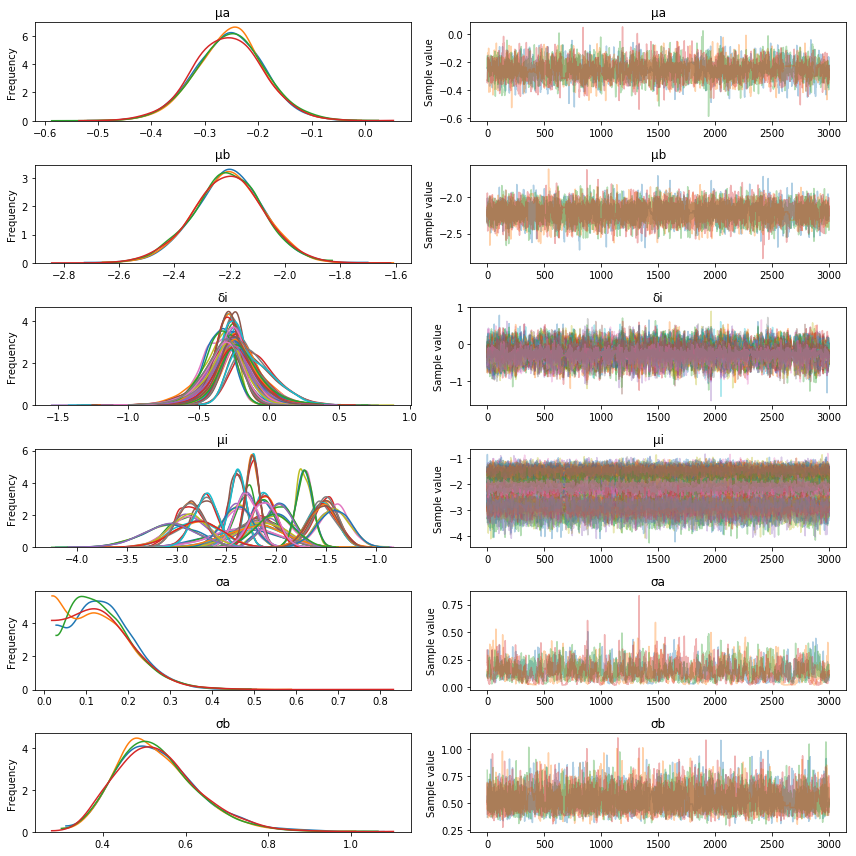

In [40]:
with pm.Model() as model_4:
    #Need to define σ and μ for both the mean and effect because they are both random
    
    σa = pm.HalfCauchy("σa",5)
    μa = pm.Normal("μa", 0, sd = 1e6)
    σb = pm.HalfCauchy("σb",5)
    μb = pm.Normal("μb", 0, sd = 1e6)
    
    δi = pm.Normal("δi", mu=μa, sd = σa, shape = 22)
    μi = pm.Normal("μi", mu=μb, sd = σb, shape = 22)
    
    pci = pm.math.invlogit(μi)
    pti = pm.math.invlogit(μi + δi)
    
    rci = pm.Binomial("rci",n_c_obs,pci,observed=r_c_obs)
    rti = pm.Binomial("rti",n_t_obs,pti,observed=r_t_obs)

    trace_4 = pm.sample(3000)
    pm.traceplot(trace_4)

## 3.2

Refer to section 4.6

Got a posterior predictive distribution for each of the traces using sample_ppc.

In [41]:
from pymc3 import sample_ppc

with model_1:
    model_1_sim = sample_ppc(trace_1, samples=500)
with model_2:
    model_2_sim = sample_ppc(trace_2, samples=500)
with model_3:
    model_3_sim = sample_ppc(trace_3, samples=500)
with model_4:
    model_4_sim = sample_ppc(trace_4, samples=500)

100%|██████████| 500/500 [00:00<00:00, 822.89it/s]


Need to plot the ppc for both the number of events in both the control and treatment groups. The dot will represent the mean of the actual observations. Whereas the histogram will be generated from sample_ppc. The greater the divergence between the apparent histogram mean and the observed means indicates the performance of each of the models.

In [42]:
def plot_ppc(model_sim):
    fig, axes = plt.subplots(1, 4, figsize=(30,5))
    for obs, sim, ax in zip(r_c_obs, model_sim['rci'].T, axes):
        ax.hist(sim,alpha=.5) 
        ax.plot(obs+0.5, 1, 'bo') #the control mean is the blue dot
    for obs, sim, ax in zip(r_t_obs, model_sim['rti'].T, axes):
        ax.hist(sim,alpha=.5)
        ax.plot(obs+0.5, 1, 'ro') #the treatment mean is the red dot

The the 4th plot is the most informative of performance, as that is where the different models seem to diverge. 

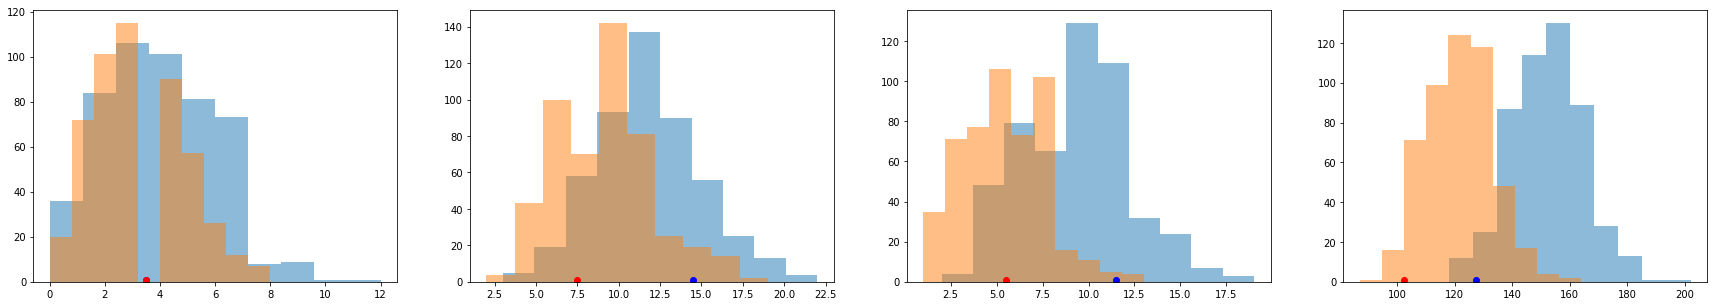

In [43]:
plot_ppc(model_1_sim)

Model 1 does not perform well, both the control and treatment distributions are misaligned from the observed mean.

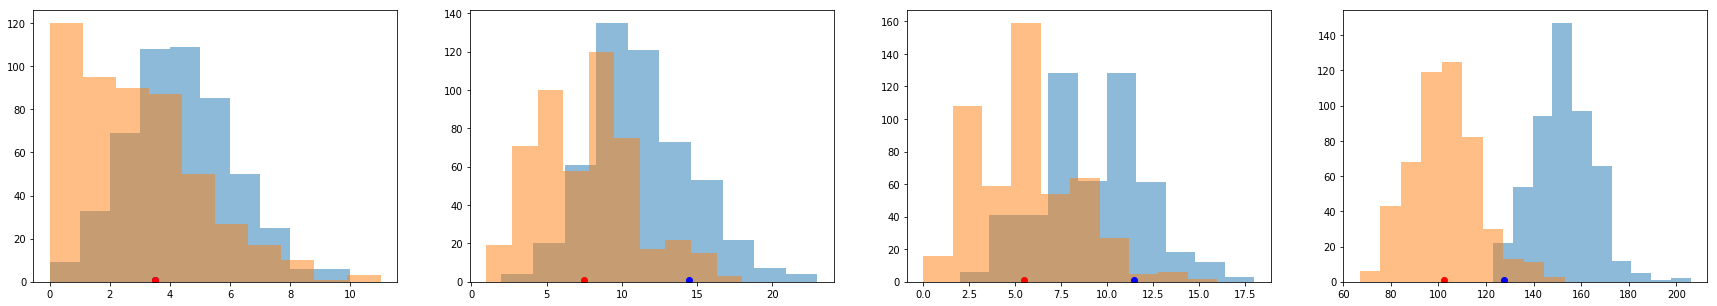

In [44]:
plot_ppc(model_2_sim)

Model 2 does not perform well, the control distribution is misaligned from the observed mean.

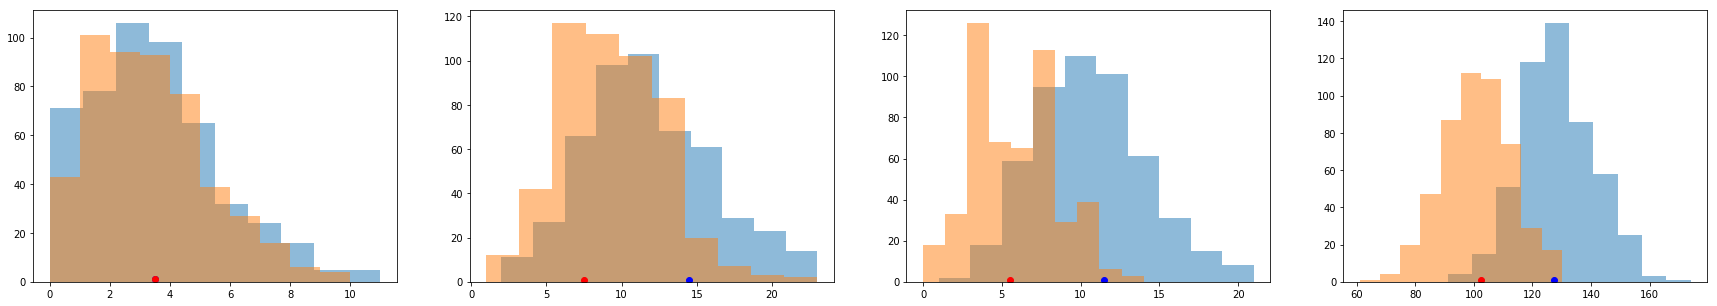

In [45]:
plot_ppc(model_3_sim)

Model 3 performs better, both the control and treatment distributions are centered around the observed means.



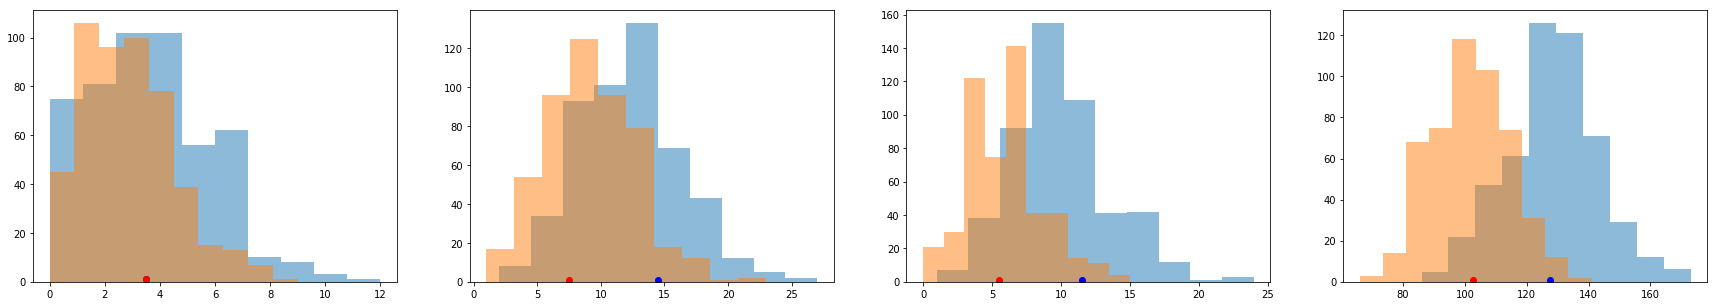

In [46]:
plot_ppc(model_4_sim)

Model 4 also performs better, both the control and treatment distributions are centered around the observed means.



## 3.3

I used the WAIC metric to gauge the approximations.

In [47]:
pm.waic(model = model_1, trace = trace_1)

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=541.2052261685737, WAIC_se=62.83613318973154, p_WAIC=14.885595777490803, var_warn=1)

In [48]:
pm.waic(model = model_2, trace = trace_2)

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=442.4934070093061, WAIC_se=55.397456374473364, p_WAIC=20.679112108743592, var_warn=1)

In [49]:
pm.waic(model = model_3, trace = trace_3)

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=287.19913307350635, WAIC_se=13.040342124456586, p_WAIC=17.66924324783655, var_warn=1)

In [50]:
pm.waic(model = model_4, trace = trace_4)

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=281.40026806659614, WAIC_se=10.514681212903632, p_WAIC=16.85266865246112, var_warn=1)

## Conclusion

The Lowest WAICs were model 3 and 4. Using PPC it looks like 1 and 2 distributions that did not accurately represent both observed means.

Therefore i would choose models 3 or 4, but probably model 4 because the WAIC was the lowest at 281.49.